# Gaussian Process and Machine Learning

In [30]:
using Plots
using Printf
using Statistics

In [42]:
include("gp.jl")

gpr (generic function with 1 method)

## Sampling from 1D Gaussian Process

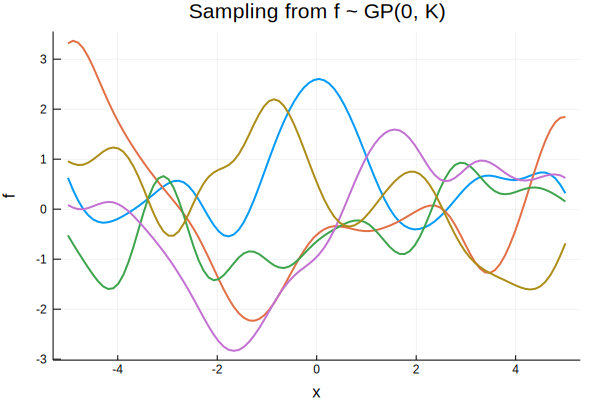

In [3]:
xs = collect(range(-5, stop = 5, length = 100))

gp = GaussianProcess(GaussianKernel(1, 1))
Plots.plot(xs, rand(gp, xs, 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

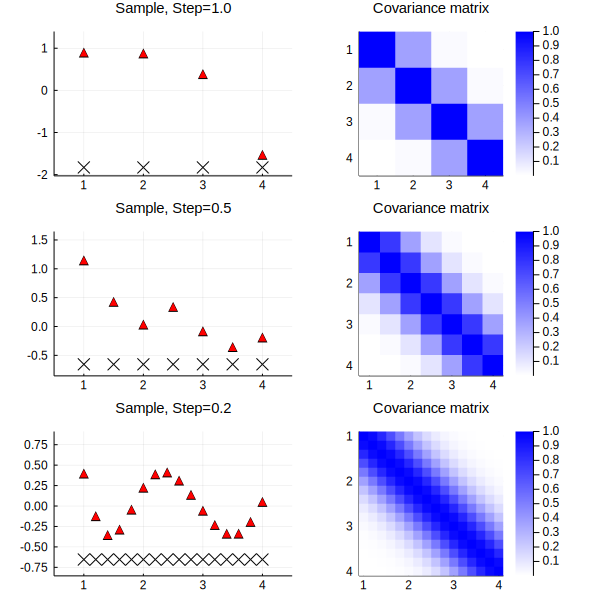

In [4]:
xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]

plts = []
for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(gp, x1)
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

In [5]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...));

## Sampling from 2D Gaussian Process

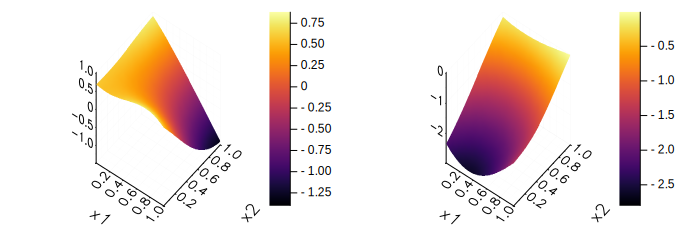

In [6]:
sample = rand(gp, pt, 2)

plts = []

for i in 1:2
    z = reshape(sample[:, i], n1, n2)
    push!(plts,
        surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
        linewidth = 2,
        framestyle = :grid,
        xlabel = "x1", ylabel = "x2", zlabel = "f"))
end

Plots.plot(plts..., layout = (1, 2), size = [700, 250])

## Kernel Types (Linear, Gaussian, Exponential, Periodic)

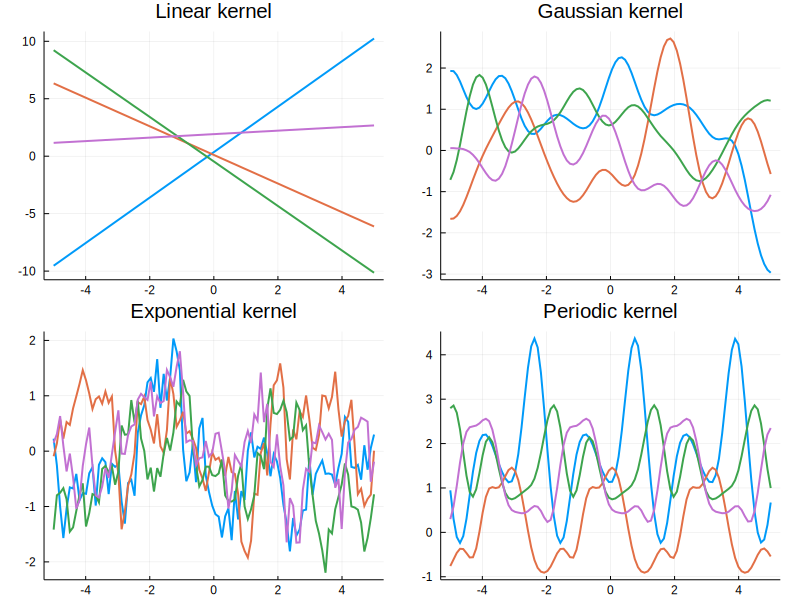

In [7]:
xs = collect(range(-5, stop = 5, length = 100))

plts = []

gp = GaussianProcess(LinearKernel())
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Linear kernel"))

gp = GaussianProcess(GaussianKernel(1, 1))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Gaussian kernel"))

gp = GaussianProcess(ExponentialKernel(1))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Exponential kernel"))

gp = GaussianProcess(PeriodicKernel(1.0, 0.5))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Periodic kernel"))

Plots.plot(plts..., layout = (2, 2), size = [800, 600])

## Linear combination

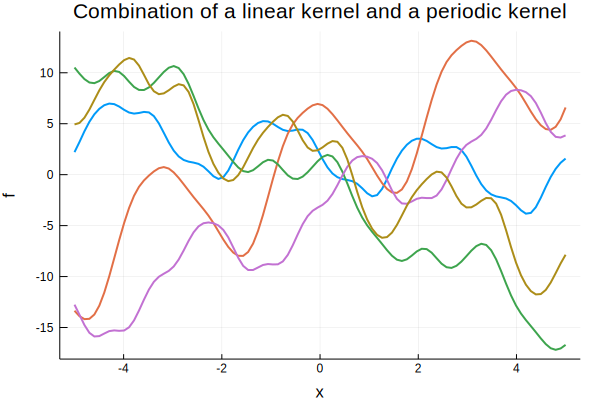

In [8]:
l_ker = 2.0 * LinearKernel() + 3.0 * PeriodicKernel(1.0, 0.5)

gp = GaussianProcess(l_ker)
Plots.plot(xs, rand(gp, xs, 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Combination of a linear kernel and a periodic kernel")

## Matérn kernel

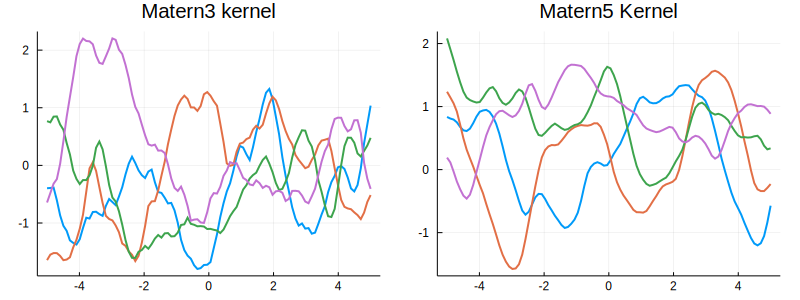

In [9]:
plts = []

gp = GaussianProcess(MaternKernel(3/2, 1.))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Matern3 kernel"))

gp = GaussianProcess(MaternKernel(5/2, 1.))
push!(plts,
    Plots.plot(xs, rand(gp, xs, 4), 
        label = "",
        linewidth = 2,
        title = "Matern5 Kernel"))

Plots.plot(plts..., layout = (1, 2), size = [800, 300])

## Gaussian Process Regression

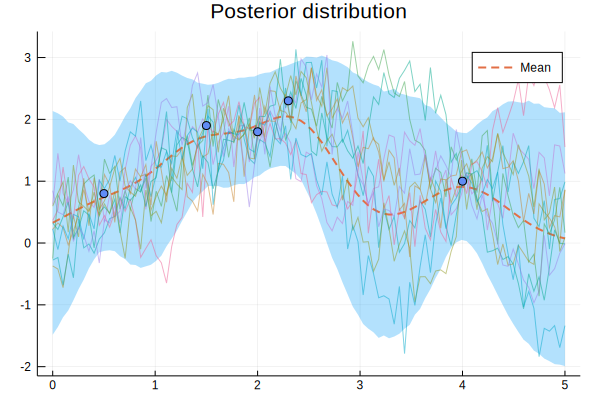

In [48]:
xs = [1.5, 4, 2, 0.5, 2.3]
ys = [1.9, 1, 1.8, 0.8, 2.3]
gp = GaussianProcess(GaussianKernel(1.0, 0.4), 0.1)
xtrain = collect(range(0, stop=5, length=100))
pred = gpr(gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)
Plots.plot!(xtrain, rand(pred, 10), label = "", linewidth = 1, linealpha = 0.5)

scatter!(xs, ys, label = "", title = "Posterior distribution")

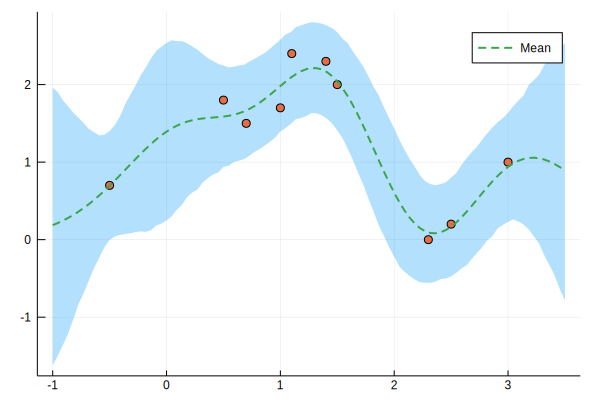

In [43]:
xs = [-0.5, 0.5, 1, 1.4, 3, 2.3, 2.5, 1.5, 1.1, 0.7]
ys = [0.7, 1.8, 1.7, 2.3, 1, 0, 0.2, 2, 2.4, 1.5]

gp = GaussianProcess(GaussianKernel(1.525, 0.689), 0.067)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
scatter!(xs, ys, label = "", title = "")
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)